In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve,auc,roc_auc_score

In [47]:
#set display option for rows & columns
pd.set_option( 'display.max_rows', None)
pd.set_option('display.max_columns', None )

In [2]:
import pandas as pd
import numpy as np
train = pd.read_csv('train_afterEDA_new.csv')
print(train.shape)

(589976, 434)


In [3]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# train.drop(["P_emaildomain", "R_emaildomain"], axis=1, inplace = True)

# 2 Featue Engineering

# 2.1 D Features

In EDA part we saw we have few negative D values, which is not possible. Since this feature represents timedelta.

Lets remove negative Data points.


In [5]:
#finding index of D features having negative values
D_features = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']
sum=0
for i in D_features:
  filt=(train[i]<0.0)
  filt = train[train[i]<0.0].index
  sum=sum+len(filt)
  print(i,filt)

print(sum)


D1 Index([], dtype='int64')
D2 Index([], dtype='int64')
D3 Index([], dtype='int64')
D4 Index([  2947,   4210,   5264,   5501,   6057,   9120, 110147, 267604, 443994,
       443998, 445022, 445930, 455103, 455668, 472840],
      dtype='int64')
D5 Index([], dtype='int64')
D6 Index([5501, 267604, 472840], dtype='int64')
D7 Index([], dtype='int64')
D8 Index([], dtype='int64')
D9 Index([], dtype='int64')
D10 Index([], dtype='int64')
D11 Index([2947, 3814, 4932, 357784, 359145, 441934, 455668], dtype='int64')
D12 Index([5501, 472840], dtype='int64')
D13 Index([], dtype='int64')
D14 Index([4085, 4097, 5501], dtype='int64')
D15 Index([  2947,   3034,   4932,   5501,   6057,   7589,  13149, 267604, 359145,
       441890, 441913, 441934, 455103, 455668, 472840],
      dtype='int64')
45


Observations:

1) Features having negative values are : D4, D6, D11, D12, D14, D15.

2) There are total 45 datapoints having less than 0 values for D features.

3) There are few index which have more than 1 feature negative values.

We can see there are 27 unique index, Lets remove them.

In [6]:
D_features = ['D4','D6','D11','D12','D14','D15']
sum = 0
for i in D_features:
  filt = train[train[i]<0.0].index
  
  for j in filt:
    train=train.drop(index=j)

print("Data point after removing negative D features", train.shape[0])


Data point after removing negative D features 589949


# 2.2 M Features

As observed in EDA part, M1 feature doesn't contribute in classification.
Lets remove it.

In [7]:
train.drop(["M1"], axis=1, inplace=True)

# 2.3 V Features

Remove V features using LGBM 

In [8]:
vfeatures=[]
for features in train.columns:
  if features.startswith("V"):
    vfeatures.append(features)
train_v = train[vfeatures]    

In [9]:
for features in vfeatures:
  train_v[features].fillna(train_v[features].median(), inplace=True)

In [10]:
V_x = train_v[:int(train.shape[0]*0.70)]
V_cv = train_v[int(train.shape[0]*0.70):]

train_y = train["isFraud"].values[:int(train.shape[0]*0.70)]
cv_y = train["isFraud"].values[int(train.shape[0]*0.70):]

In [11]:
clf = LGBMClassifier()
clf.fit( V_x, train_y)
print("Train AUC :",roc_auc_score(train_y, clf.predict_proba(V_x)[:,1]))
print("CV AUC :",roc_auc_score(cv_y, clf.predict_proba(V_cv)[:,1]))

[LightGBM] [Info] Number of positive: 14481, number of negative: 398483
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.329049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23232
[LightGBM] [Info] Number of data points in the train set: 412964, number of used features: 336
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035066 -> initscore=-3.314827
[LightGBM] [Info] Start training from score -3.314827
Train AUC : 0.882612989012955
CV AUC : 0.8438888915918275


In [12]:
Vremove=[]
for j,i in enumerate(clf.feature_importances_):
  if i<4:
    Vremove.append(vfeatures[j])  
len(Vremove)  

140

In [13]:
Vremove

['V1',
 'V2',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V21',
 'V22',
 'V27',
 'V28',
 'V31',
 'V32',
 'V39',
 'V41',
 'V42',
 'V43',
 'V46',
 'V57',
 'V65',
 'V66',
 'V68',
 'V71',
 'V88',
 'V89',
 'V93',
 'V95',
 'V97',
 'V98',
 'V101',
 'V103',
 'V104',
 'V106',
 'V107',
 'V110',
 'V111',
 'V113',
 'V114',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V125',
 'V132',
 'V135',
 'V141',
 'V142',
 'V144',
 'V146',
 'V148',
 'V153',
 'V154',
 'V155',
 'V157',
 'V161',
 'V163',
 'V166',
 'V167',
 'V168',
 'V172',
 'V173',
 'V175',
 'V176',
 'V177',
 'V179',
 'V181',
 'V182',
 'V183',
 'V185',
 'V186',
 'V188',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V199',
 'V202',
 'V204',
 'V211',
 'V216',
 'V217',
 'V223',
 'V225',
 'V228',
 'V230',
 'V231',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V240',
 'V241',
 'V242',
 'V244',
 'V246',
 'V247',
 'V248',
 'V249',
 'V250',
 'V251',
 'V252',
 'V254',
 'V2

In [14]:
#dropping above listed V features
print(len(vfeatures))
for v in Vremove:
    vfeatures.remove(v)
print(len(vfeatures))    

339
199


In [15]:
train_v = train[vfeatures]
for V in vfeatures:
  train_v[V].fillna(train_v[V].median(), inplace = True)

In [16]:
V_x = train_v[:int(train.shape[0]*0.70)]
V_cv = train_v[int(train.shape[0]*0.70):]

In [17]:
clf = LGBMClassifier()
clf.fit(V_x, train_y)
print("Train AUC :",roc_auc_score(train_y, clf.predict_proba(V_x)[:,1]))
print("CV AUC :",roc_auc_score(cv_y, clf.predict_proba(V_cv)[:,1]))

[LightGBM] [Info] Number of positive: 14481, number of negative: 398483
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17894
[LightGBM] [Info] Number of data points in the train set: 412964, number of used features: 199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035066 -> initscore=-3.314827
[LightGBM] [Info] Start training from score -3.314827
Train AUC : 0.8813032744063256
CV AUC : 0.8415063131110964


In [18]:
#Removing redundant train and test features

train.drop(Vremove,axis=1,inplace=True)

In [19]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train.shape

(589949, 293)

# 2.5 Id Features

In [21]:
id_train_df = train[['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11','id_12','id_13','id_14','id_15','id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_34','id_35','id_36','id_37','id_38']]

In [22]:
percent_missing = id_train_df.isnull().sum() * 100 / len(id_train_df)
missing_value_df = pd.DataFrame({'column_name': id_train_df.columns,
                                 'percent_missing': percent_missing})

In [23]:
missing_value_df.sort_values('percent_missing', inplace=True)

In [24]:
missing_value_df

,column_name,percent_missing
id_01,id_01,75.633656
id_12,id_12,75.633656
id_36,id_36,76.183195
id_35,id_35,76.183195
id_37,id_37,76.183195
id_15,id_15,76.183195
id_38,id_38,76.183195
id_29,id_29,76.184382
id_11,id_11,76.184382
id_28,id_28,76.184382


Apart from the important features which contribute in classification, I will remove all the columns with more that 85% of missing values from train.

In [25]:
train.drop(["id_03","id_04","id_07","id_08","id_09","id_10","id_14","id_18","id_21","id_22","id_23","id_24","id_25","id_26","id_27"], axis = 1, inplace=True)

In [26]:
#Train and test data shape after Feature Engineering

print("train shape :", train.shape)


train shape : (589949, 278)


# Removing highly co-related D and C features

D features

In [27]:
train_df = train

In [28]:
D_features_train_df = train_df[['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']]

In [29]:
cor = D_features_train_df.corr()
cor

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
D1,1.000000,0.981331,0.280298,0.585691,0.055095,0.526125,0.204737,0.050114,0.007903,0.562146,0.592650,0.521733,0.370859,0.154763,0.638953
D2,0.981331,1.000000,0.265999,0.569940,0.238240,0.601186,0.453881,0.275125,0.043056,0.525954,0.563220,0.669204,0.395408,0.196338,0.618259
D3,0.280298,0.265999,1.000000,0.149065,0.707265,0.305281,0.817802,0.194556,0.007447,0.092381,0.055442,0.349720,0.136914,0.028412,0.141690
D4,0.585691,0.569940,0.149065,1.000000,0.313514,0.956715,0.574235,0.162985,0.041649,0.636934,0.657810,0.999999,0.384316,0.135346,0.751526
D5,0.055095,0.238240,0.707265,0.313514,1.000000,0.551321,0.986414,0.250031,0.032320,0.116790,0.058500,0.565342,0.133772,0.064332,0.188576
D6,0.526125,0.601186,0.305281,0.956715,0.551321,1.000000,0.506328,0.185644,0.040161,0.463146,NaN,0.976672,0.420533,0.207538,0.701052
D7,0.204737,0.453881,0.817802,0.574235,0.986414,0.506328,1.000000,0.224159,0.025723,0.107563,NaN,0.553936,0.122739,0.035485,0.285704
D8,0.050114,0.275125,0.194556,0.162985,0.250031,0.185644,0.224159,1.000000,0.066098,0.168628,NaN,0.157698,0.522159,0.080744,0.226710
D9,0.007903,0.043056,0.007447,0.041649,0.032320,0.040161,0.025723,0.066098,1.000000,0.063367,NaN,0.026613,0.025161,0.042965,0.054643
D10,0.562146,0.525954,0.092381,0.636934,0.116790,0.463146,0.107563,0.168628,0.063367,1.000000,0.609654,0.018188,0.277146,0.336939,0.712262


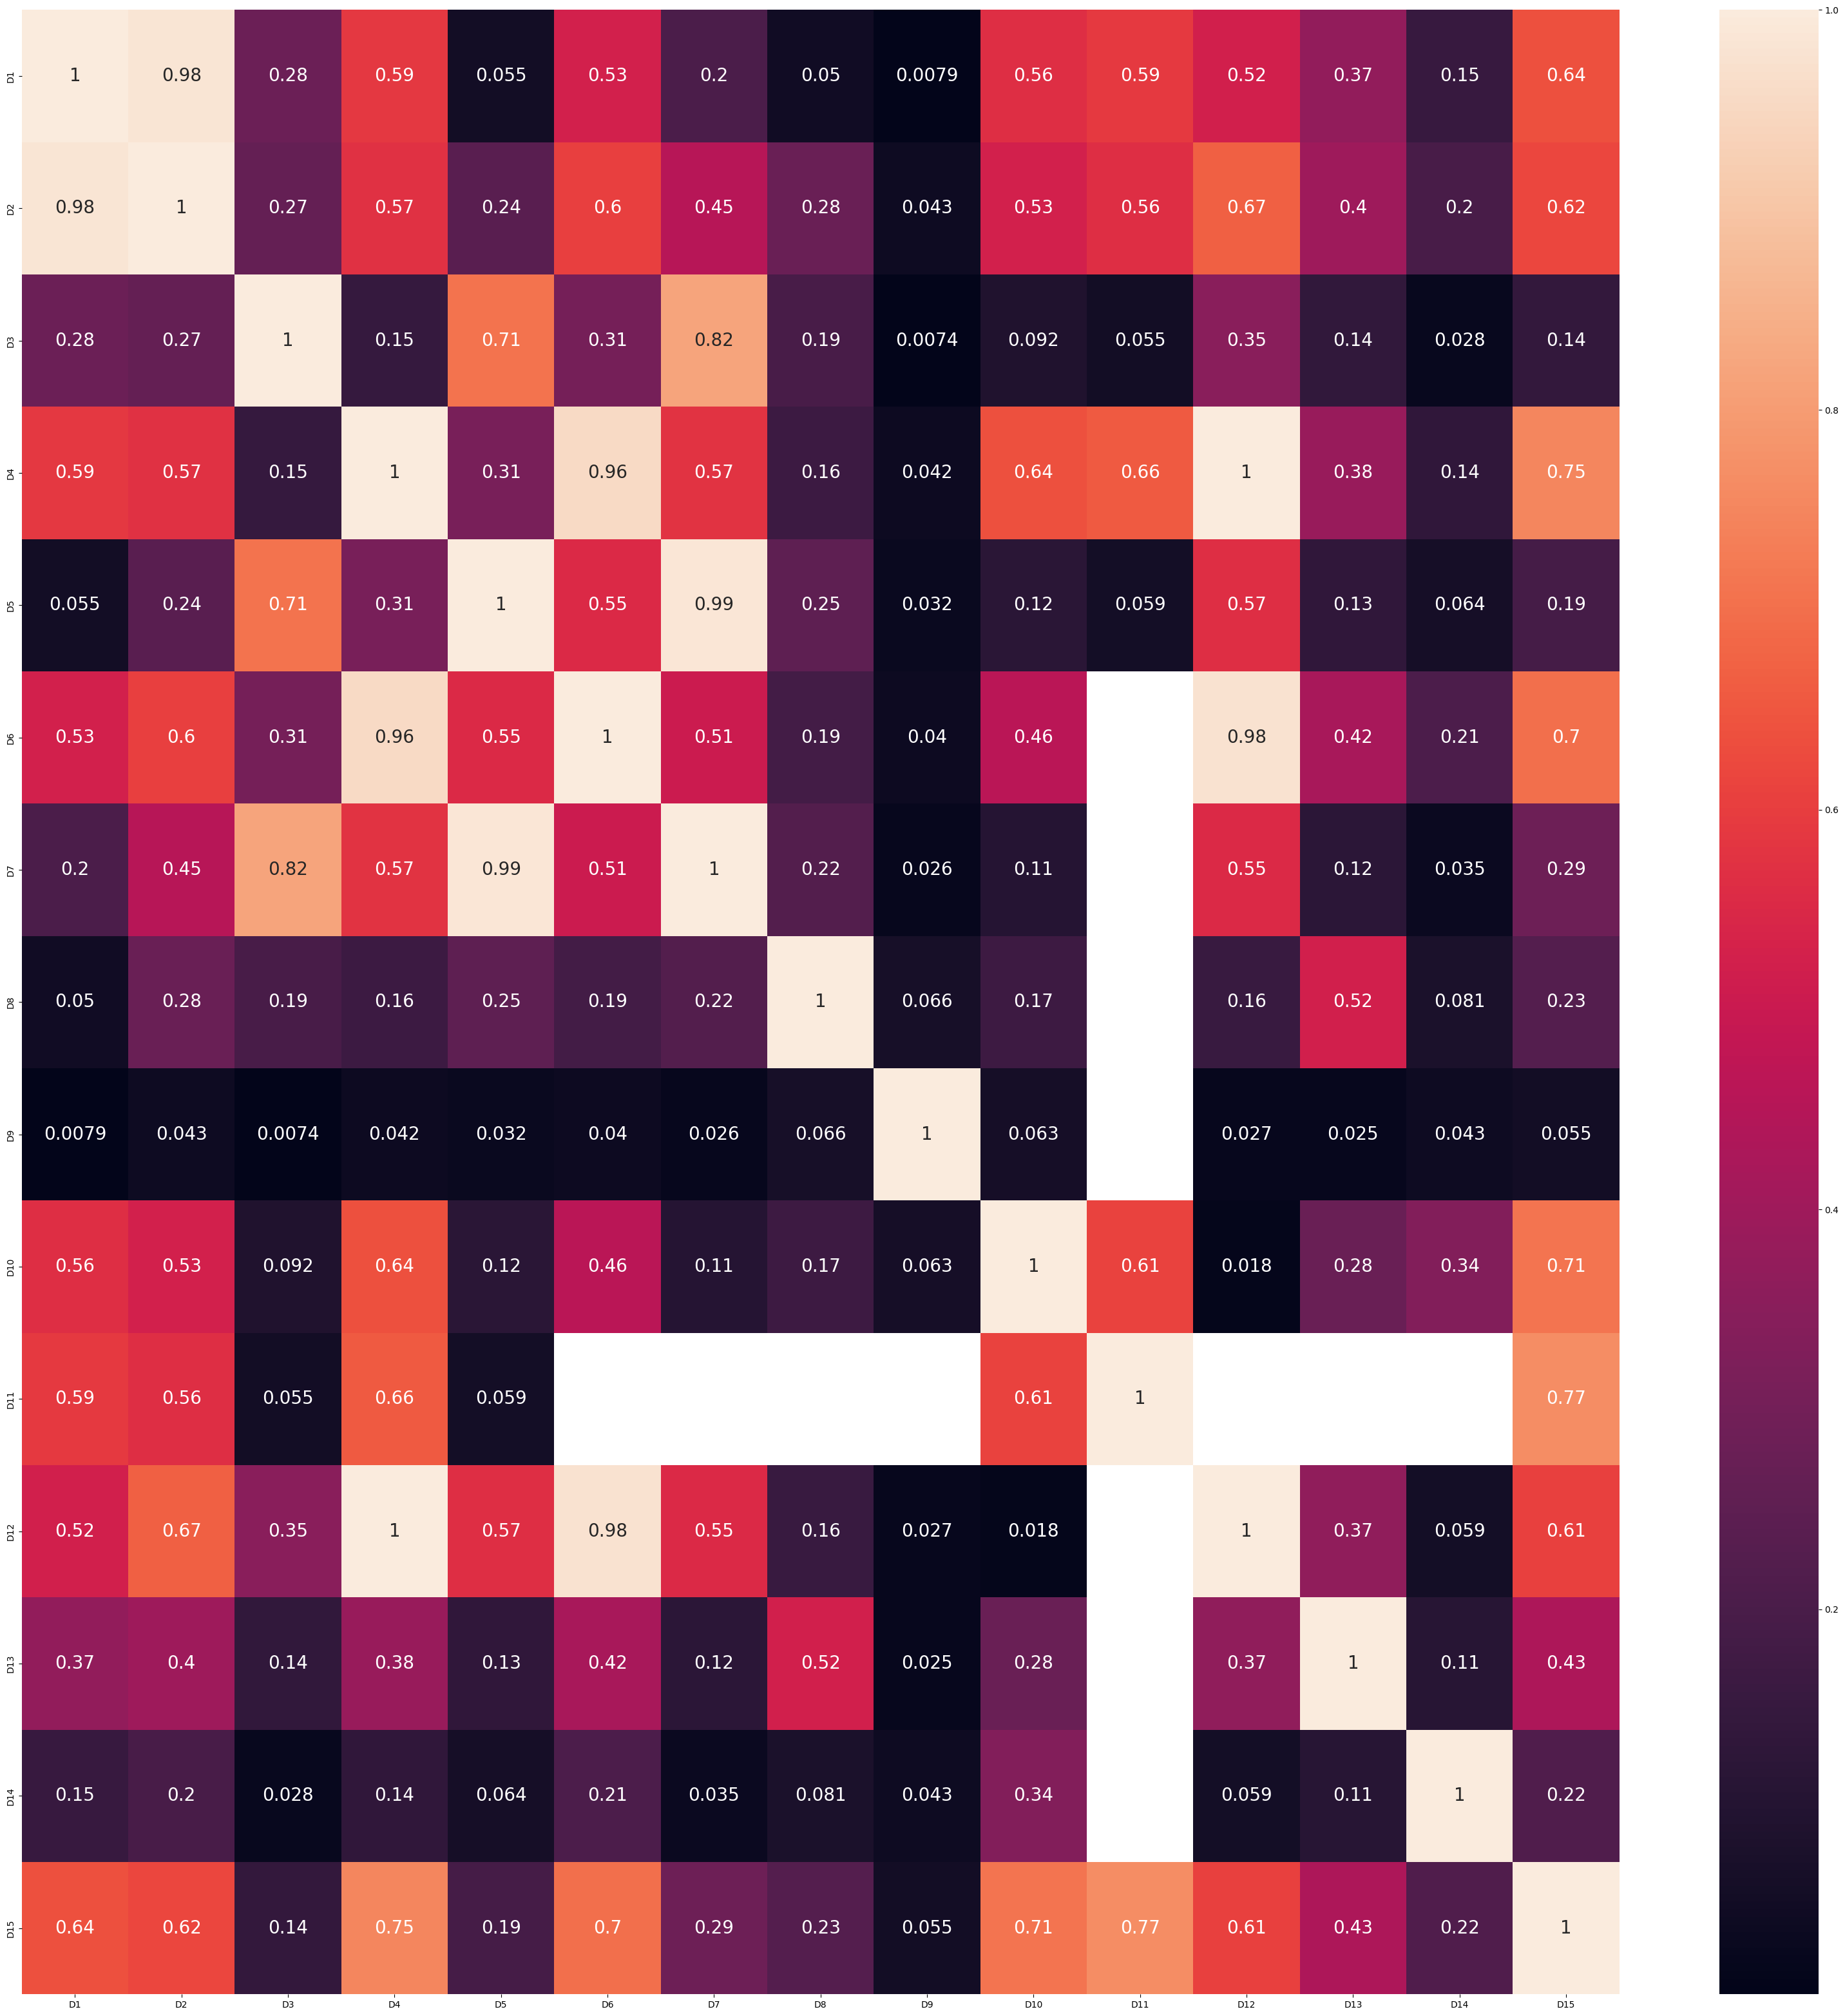

In [30]:
plt.figure(figsize = (40,40))
sns.heatmap(data = cor, annot = True, annot_kws = {
                'fontsize' : 20});

In [31]:
upper = cor.where(np.triu(np.ones(cor.shape), k = 1).astype(bool))

In [32]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [33]:
to_drop

['D2', 'D6', 'D7', 'D12']

In [34]:
train_df.drop(to_drop, axis = 1, inplace = True)

C features

In [35]:
C_features_train_df = train_df[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']]

In [36]:
cor = C_features_train_df.corr()
cor

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
C1,1.000000,0.985202,-0.004896,0.915547,0.335451,0.985657,0.692517,0.872788,0.357944,0.844043,0.996479,0.694775,0.699730,0.950994
C2,0.985202,1.000000,-0.004480,0.925111,0.247305,0.953525,0.767979,0.919789,0.262962,0.899074,0.983838,0.772550,0.635228,0.895904
C3,-0.004896,-0.004480,1.000000,-0.001366,-0.008109,-0.006010,-0.001613,-0.000440,-0.010084,-0.001024,-0.004696,-0.001721,-0.008568,-0.006093
C4,0.915547,0.925111,-0.001366,1.000000,-0.012756,0.905224,0.668491,0.901180,-0.015862,0.864375,0.927645,0.667152,0.400146,0.803997
C5,0.335451,0.247305,-0.008109,-0.012756,1.000000,0.371011,-0.009296,-0.012611,0.925781,-0.012262,0.308095,-0.009258,0.867990,0.544813
C6,0.985657,0.953525,-0.006010,0.905224,0.371011,1.000000,0.598375,0.811429,0.401492,0.777344,0.987563,0.597272,0.716727,0.973415
C7,0.692517,0.767979,-0.001613,0.668491,-0.009296,0.598375,1.000000,0.921312,-0.011560,0.945939,0.702202,0.998147,0.362784,0.506837
C8,0.872788,0.919789,-0.000440,0.901180,-0.012611,0.811429,0.921312,1.000000,-0.015683,0.992506,0.884242,0.921137,0.415432,0.706329
C9,0.357944,0.262962,-0.010084,-0.015862,0.925781,0.401492,-0.011560,-0.015683,1.000000,-0.015248,0.334428,-0.011355,0.852870,0.572618
C10,0.844043,0.899074,-0.001024,0.864375,-0.012262,0.777344,0.945939,0.992506,-0.015248,1.000000,0.856273,0.944043,0.413634,0.674779


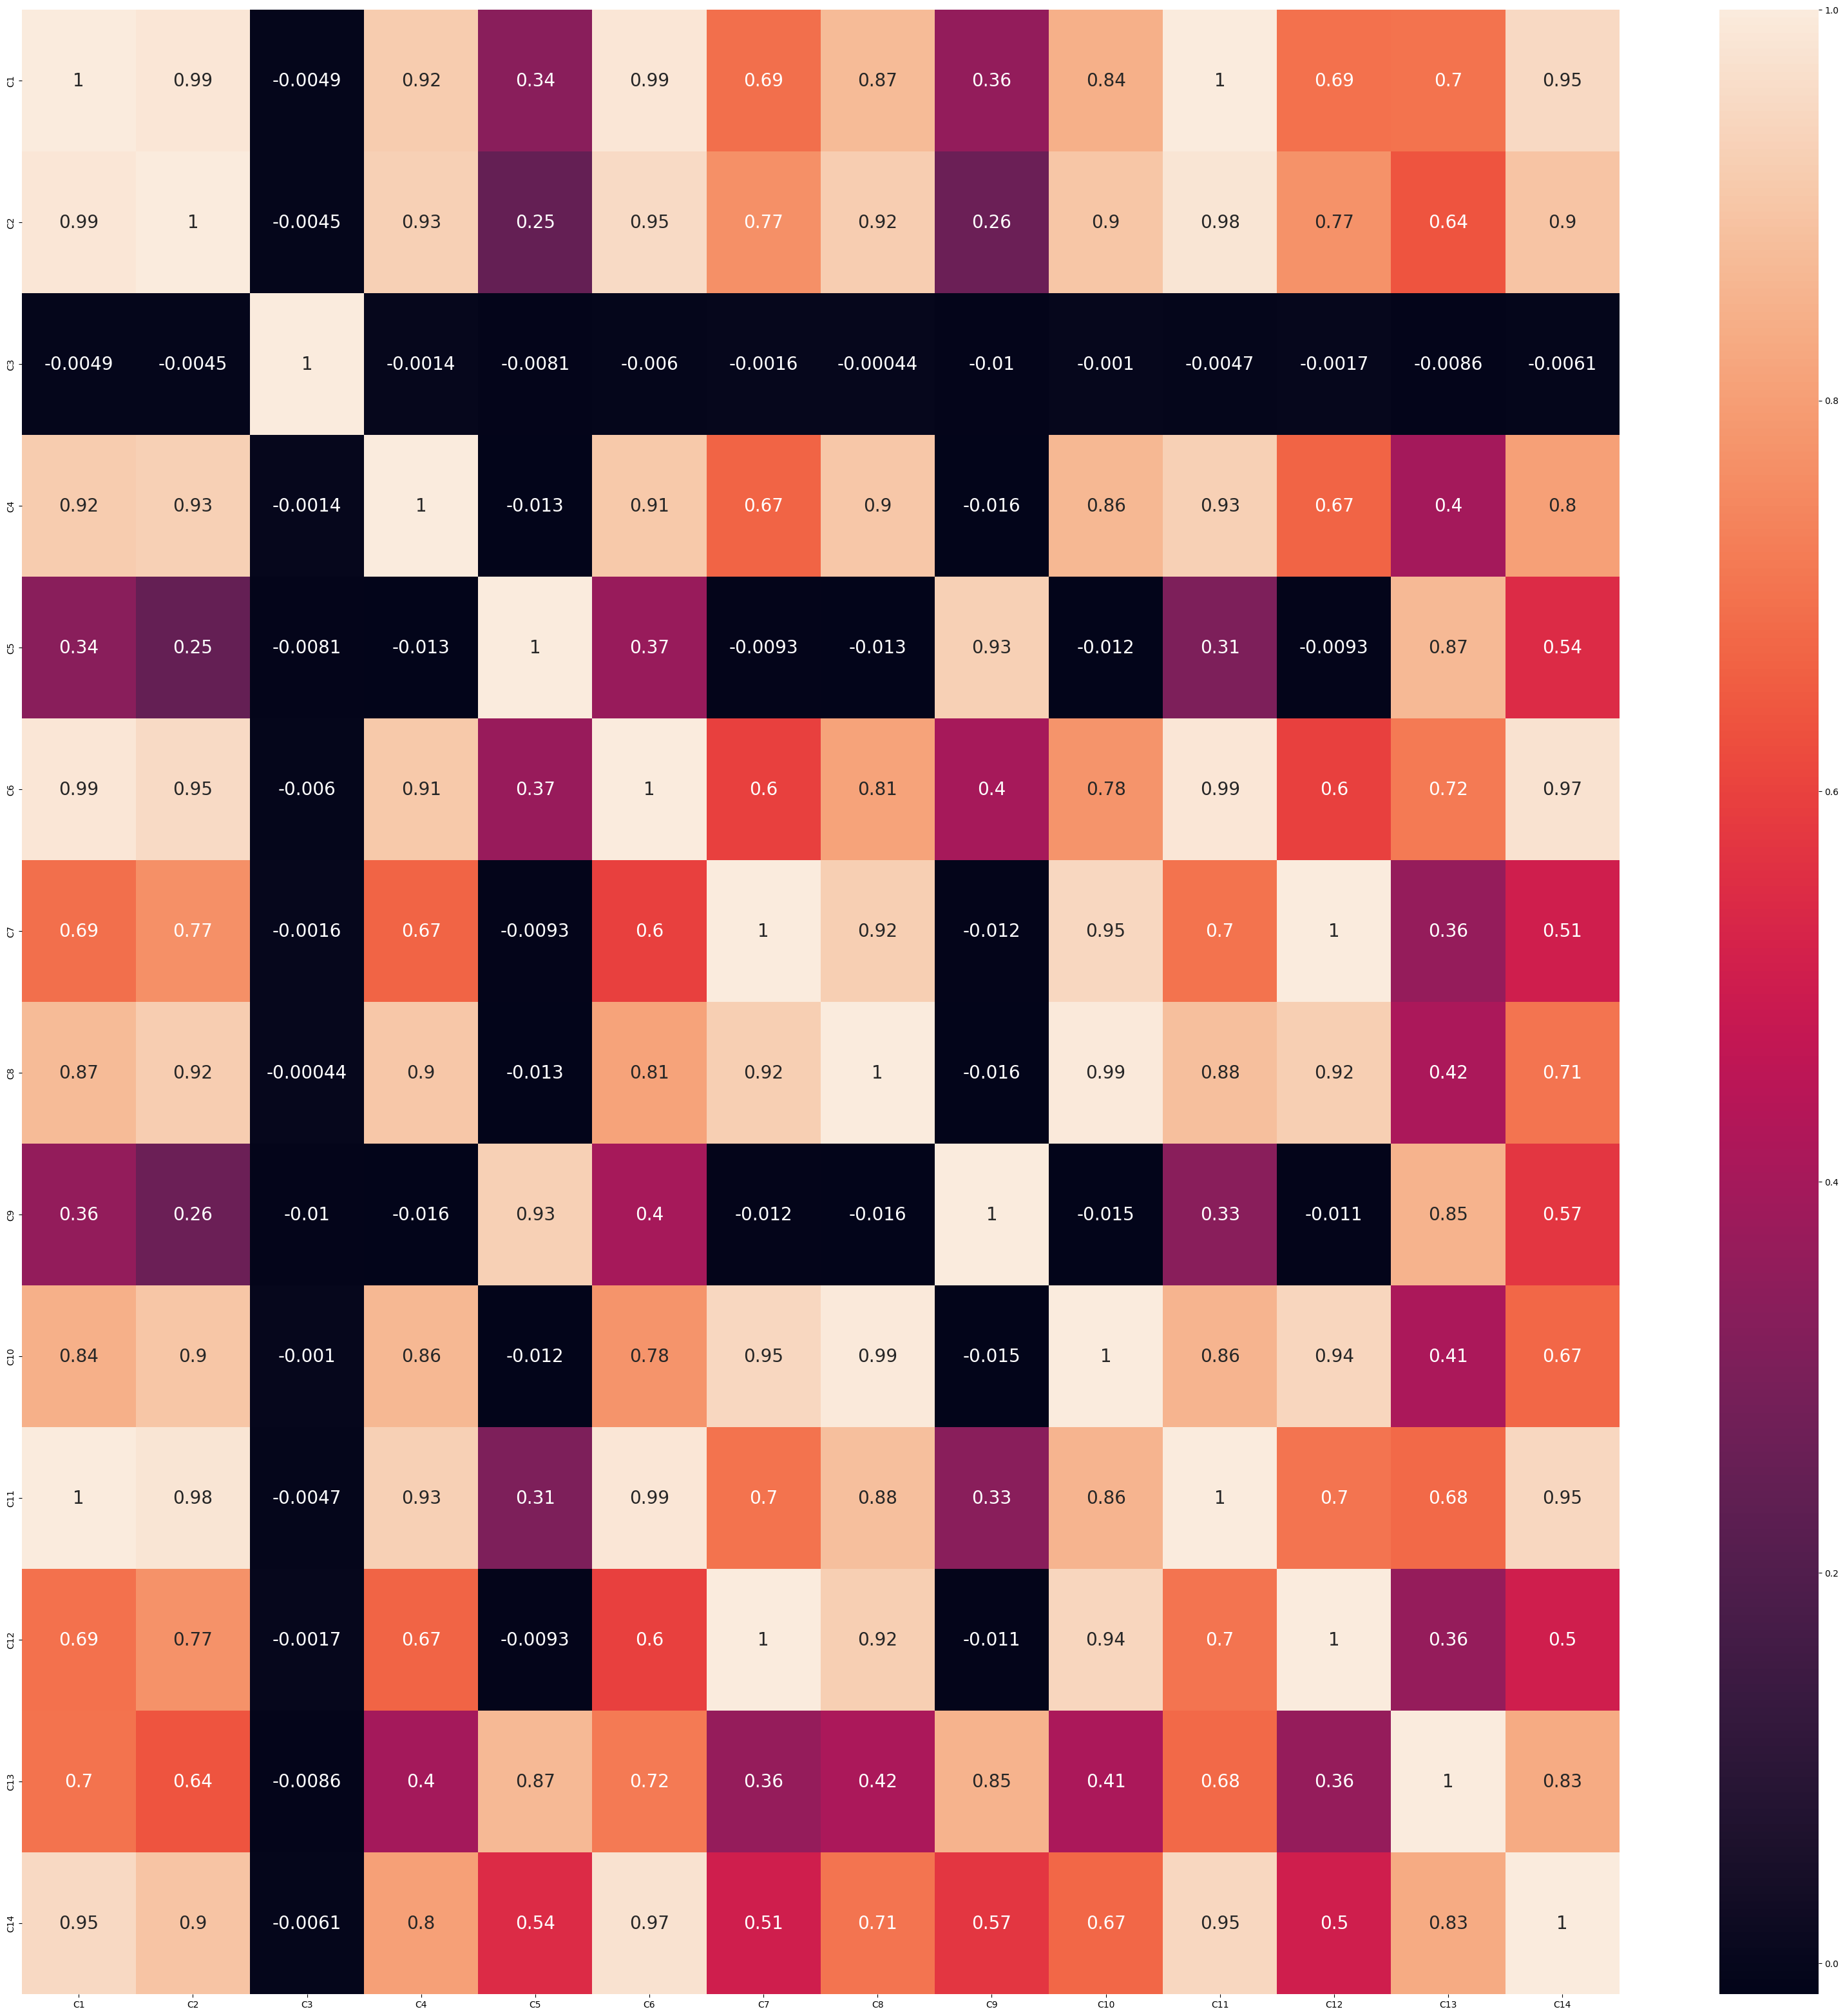

In [37]:
plt.figure(figsize = (40, 40))
sns.heatmap(data = cor, annot = True, annot_kws = {
                'fontsize' : 20});

In [38]:
upper = cor.where(np.triu(np.ones(cor.shape), k = 1 ).astype(bool))

In [39]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [40]:
to_drop

['C2', 'C6', 'C10', 'C11', 'C12', 'C14']

In [41]:
train_df.drop(to_drop, axis = 1, inplace = True)

In [42]:
del D_features_train_df, C_features_train_df

In [43]:
train_df.columns.to_list()

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C3',
 'C4',
 'C5',
 'C7',
 'C8',
 'C9',
 'C13',
 'D1',
 'D3',
 'D4',
 'D5',
 'D8',
 'D9',
 'D10',
 'D11',
 'D13',
 'D14',
 'D15',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V3',
 'V4',
 'V5',
 'V6',
 'V12',
 'V13',
 'V19',
 'V20',
 'V23',
 'V24',
 'V25',
 'V26',
 'V29',
 'V30',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V40',
 'V44',
 'V45',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V67',
 'V69',
 'V70',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V90',
 'V91',
 'V92',
 'V94',
 'V96',
 'V99',
 'V100',
 'V102',
 'V105',
 'V108',
 'V109',
 'V112',
 'V115',
 'V123',


# Removing infinity values

In [ ]:
# any infitinte value in dataset
train_df.isin([np.inf, -np.inf]).sum().any()

In [ ]:
# There are few infinity values
df = train_df.isin([np.inf, -np.inf]).sum()[-2:]
print(df)

In [ ]:
del df

# Data Imputation

In [44]:
# lets convert this inf value to NaN then impute using the mean

train_df.replace([np.inf, -np.inf], np.nan, inplace = True)


In [48]:
train_df.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C3,C4,C5,C7,C8,C9,C13,D1,D3,D4,D5,D8,D9,D10,D11,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V3,V4,V5,V6,V12,V13,V19,V20,V23,V24,V25,V26,V29,V30,V33,V34,V35,V36,V37,V38,V40,V44,V45,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V58,V59,V60,V61,V62,V63,V64,V67,V69,V70,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V90,V91,V92,V94,V96,V99,V100,V102,V105,V108,V109,V112,V115,V123,V124,V126,V127,V128,V129,V130,V131,V133,V134,V136,V137,V138,V139,V140,V143,V145,V147,V149,V150,V151,V152,V156,V158,V159,V160,V162,V164,V165,V169,V170,V171,V174,V178,V180,V184,V187,V189,V198,V200,V201,V203,V205,V206,V207,V208,V209,V210,V212,V213,V214,V215,V218,V219,V220,V221,V222,V224,V226,V227,V229,V232,V233,V234,V243,V245,V253,V256,V258,V259,V261,V262,V264,V265,V266,V267,V268,V269,V270,V271,V272,V274,V276,V277,V278,V279,V280,V281,V282,V283,V285,V287,V288,V289,V291,V292,V294,V295,V296,V298,V300,V301,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V320,V321,V323,V326,V329,V331,V332,V335,V336,V339,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,13.0,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,0.0,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
train_df.shape

(589949, 268)

In [ ]:
# # impute numerical value by median for each feature

# for i in train_df.columns:
#     if train_df[i].dtypes == 'int64' or train_df[i].dtypes == 'int32' or train_df[i].dtypes == 'int16' or train_df[i].dtypes == 'int8' or train_df[i].dtypes == 'float64' or train_df[i].dtypes == 'float32' or train_df[i].dtypes == 'float16' :
#         train_df[i].fillna(train_df[i].median(), inplace = True )
        

In [ ]:
# # imputation of categorical features by mode 

# for i in train_df.columns:
#     if train_df[i].dtypes == 'object':
#         train_df[i].fillna(train_df[i].mode()[0], inplace = True)


In [ ]:
# train_df.isnull().sum().any()

In [ ]:
# # encoding categorical feature before model training using label encoder
# from sklearn.preprocessing import LabelEncoder

# for i in train_df.columns:
#   if train_df[i].dtypes == "object":
#     le = LabelEncoder()
#     train_df[i] = le.fit_transform(train_df[i].astype(str).values)


# Saving the feature Engineered dataset into new csv file.


In [34]:
# train.to_csv("train_afterFE.csv", index = False)

In [49]:
train_df.to_csv("train_afterFE1_new.csv", index = False)